# Assignment 1 : Thompson Sampling for Multi-armed Bandit

###### Due date : 22/01/2018

###### By : Julien Roy and David Kanaa

### Section 1 : Summary of Thompson Sampling

Thompson Sampling is an approach that aims to balance the exploration and exploitation dilemma in RL or decision-making problems. It is particularly useful in online decision problems and can be applied to a wide variety of problem settings. It achieves better results than simpler algorithm such as $\epsilon$-greedy by allocating its exploration effort intelligently, based on the uncertainty around each action's value estimation, instead of wasting time by simply exploring every action with the same probability.

The process is simple. The agent uses a prior based on which the reward of each action is distributed. At each timestep, instead of greedily choosing the action that maximizes the expected reward based on the previous sequence, it greedily chooses an action according to a set of *sampled* action-values. It then simply execute the chosen action, collects the reward, and updates its model for that action. As time passes, its estimated reward distributions over each action become more and more accurate, and their variance diminish, according it to stabilize its behavior by choosing the optimal action every timestep.

**Thompson Sampling Algorithm** (taken from [1])

**for** t = 1,2,... **do**
1. Sample $\hat{\theta}$ ~ $p$ (where $p$ is our model's distribution)
2. Choose action $x_t$ that maximizes the expected reward given $x_t$, according to $\hat{\theta}$
3. Apply $x_t$ and observe $y_t$
4. Update the distribution $p$


The strengh of Thompson sampling lies in the fact that the exploration is driven by the amount of uncertainty over each action. An action that has been chosen many times but hasn't the best estimated expectation will be written off, but an action that has a low average reward but has only been selected a few times will still have high variance and therefore should produce, from time to time, a higher sample that will allow it to be explored further.

As mentioned earlier, Thompson Sampling is well suited for online decision problems requiring exploration. However, it doesn't perform well on sequential or highly non-stationary problems, or on more sophisticated problems in which some action's result are informative regarding which action should be performed next.



[1] : Russo, D., Van Roy, B., Kazerouni, A., & Osband, I. (2017). A Tutorial on Thompson Sampling. arXiv preprint arXiv:1707.02038.

### Section 2 : Implementation and Comparisons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
% matplotlib inline

###### Example of 10-arms Bandit with arms' mean normally distributed

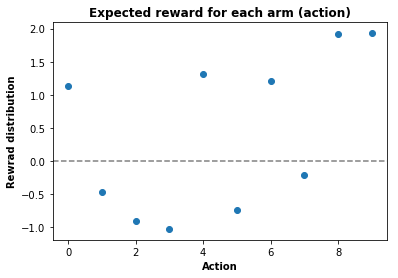

In [2]:
means = np.random.normal(0., 1., size=(10,))

plt.scatter(np.arange(10), means)
plt.axhline(y=0., color='gray', linestyle='--')
plt.xlabel("Action", fontweight='bold')
plt.ylabel("Rewrad distribution", fontweight='bold')
plt.title("Expected reward for each arm (action)", fontweight='bold')
plt.show()

###### Problem setups

In [3]:
class BanditMachine(object):
    
    def __init__(self):
        self.means = np.random.normal(0., 1., size=(10,))
    
    def press_arm(self, arm_id):
        return np.random.normal(self.means[arm_id], 1.)

###### Algorithms

In [4]:
def e_greedy_algorithm(e, bandit, max_steps):
    
    reward_log = []
    action_log = []
    regret_log = []
    optimal_action = np.argmax(bandit.means)
    
    # Initializes Q_t(a) and N(a)
    action_values = np.zeros(shape=(10,), dtype=np.float) # estimates of the real action values, which are the bandit.means
    action_freq = np.zeros(shape=(10,), dtype=np.int)

    for t in range(1, max_steps+1):

        # Action selection (epsilon-greedy)
        greed = np.random.uniform()
        if greed < e:
            a_t = np.random.randint(low=0, high=10)
        else:
            a_t = np.argmax(action_values)
        
        # Plays the bandit machine and get the reward
        R_t = bandit.press_arm(a_t)

        # Updates the action value
        action_freq[a_t] += 1
        action_values[a_t] = action_values[a_t] + (1 / action_freq[a_t]) * (R_t - action_values[a_t])
        
        reward_log.append(R_t)
        action_log.append(a_t)
        regret_log.append(bandit.means[optimal_action] - R_t)
    
    optimal_action_log = (np.array(action_log) == optimal_action)
    return reward_log, optimal_action_log, regret_log

In [5]:
def UCB_algorithm(c, bandit, max_steps):
    
    reward_log = []
    action_log = []
    regret_log = []
    optimal_action = np.argmax(bandit.means)
    
    # Initializes Q_t(a) and N(a)
    action_values = np.zeros(shape=(10,), dtype=np.float) # estimates of the real action values, which are the bandit.means
    action_freq = np.ones(shape=(10,), dtype=np.int)

    for t in range(1, max_steps+1):
        
        # Action selection (UCB)
        a_t = np.argmax(action_values + c * np.sqrt(np.log(t) / action_freq))
    
        # Plays the bandit machine and get the reward
        R_t = bandit.press_arm(a_t)

        # Updates the action value
        action_freq[a_t] += 1
        action_values[a_t] = action_values[a_t] + (1 / action_freq[a_t]) * (R_t - action_values[a_t])

        reward_log.append(R_t)
        action_log.append(a_t)
        regret_log.append(bandit.means[optimal_action] - R_t)
        
    optimal_action_log = (np.array(action_log) == optimal_action)
    return reward_log, optimal_action_log, regret_log

###### Hyper-parameter search

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:22<00:00, 87.10it/s]


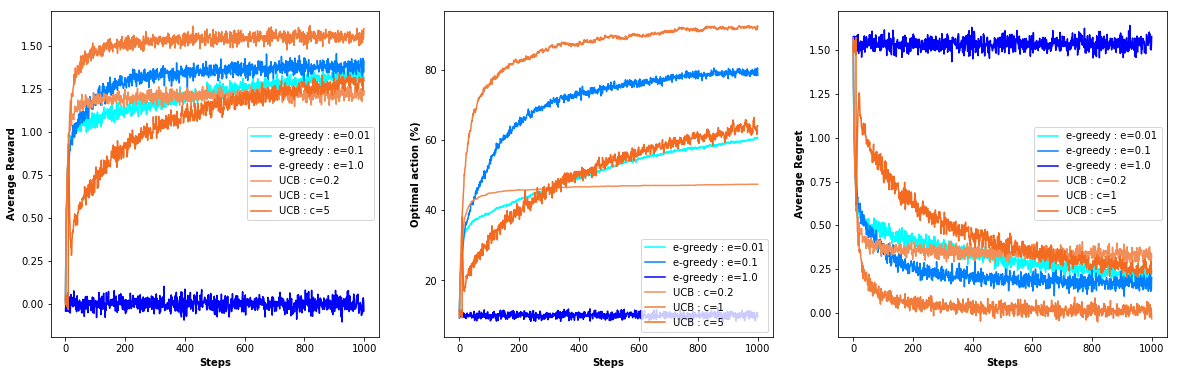

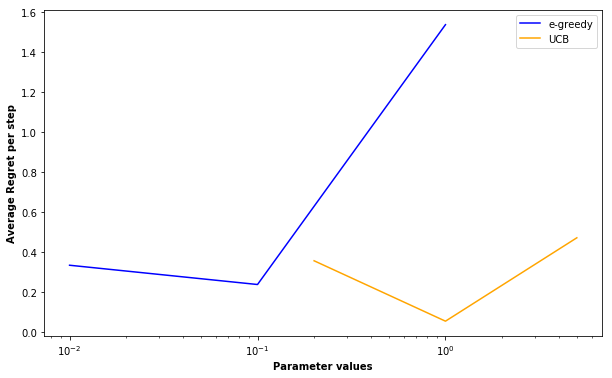

In [17]:
def hyperparameter_search(runs):
    """
        runs : a list of tuples as (algo, [hyperparams])
    """
    max_steps = 1000
    n_machines = 2000

    plt.figure(1, figsize=(20, 6))
    plt.figure(2, figsize=(10, 6))

    # EPSILONS GREEDY -------------------------------------
    epsilons = [0.01, 0.1, 1.]
    avg_regret_per_step = []
    for col, e in zip(['#00FFFF', '#0080FF', '#0000FF'], epsilons):
        master_reward_log = np.zeros(shape=(n_machines, max_steps), dtype=np.float)
        master_action_log = np.zeros(shape=(n_machines, max_steps), dtype=np.bool)
        master_regret_log = np.zeros(shape=(n_machines, max_steps), dtype=np.float)

        for i in tqdm(range(n_machines)):
            bandit = BanditMachine()
            reward_log, optimal_action_log, regret_log = e_greedy_algorithm(e, bandit, max_steps)

            master_reward_log[i, :] = reward_log
            master_action_log[i, :] = optimal_action_log
            master_regret_log[i, :] = regret_log

        avg_reward_log = np.mean(master_reward_log, axis=0)
        avg_action_log = np.mean(master_action_log, axis=0) * 100.
        avg_regret_log = np.mean(master_regret_log, axis=0)
        avg_regret_per_step.append(np.mean(avg_regret_log))

        plt.figure(1)
        plt.subplot(1,3,1)
        plt.plot(range(max_steps), avg_reward_log, color=col, label="e-greedy : e={}".format(e))
        plt.xlabel("Steps", fontweight='bold')
        plt.ylabel("Average Reward", fontweight='bold')
        plt.legend(loc='best')

        plt.subplot(1,3,2)
        plt.plot(range(max_steps), avg_action_log, color=col, label="e-greedy : e={}".format(e))
        plt.xlabel("Steps", fontweight='bold')
        plt.ylabel("Optimal action (%)", fontweight='bold')
        plt.legend(loc='best')

        plt.subplot(1,3,3)
        plt.plot(range(max_steps), avg_regret_log, color=col, label="e-greedy : e={}".format(e))
        plt.xlabel("Steps", fontweight='bold')
        plt.ylabel("Average Regret", fontweight='bold')
        plt.legend(loc='best')

    plt.figure(2)
    plt.semilogx(epsilons, avg_regret_per_step, color='blue', label="e-greedy")
    plt.xlabel("Parameter values", fontweight='bold')
    plt.ylabel("Average Regret per step", fontweight='bold')
    plt.legend(loc='best')

    # UCB ---------------------------------------------------------
    c_s = [0.2, 1, 5]
    avg_regret_per_step = []
    for col, c in zip(['#f28f59', '#f27c3c', '#f26b21'], c_s):
        master_reward_log = np.zeros(shape=(n_machines, max_steps), dtype=np.float)
        master_action_log = np.zeros(shape=(n_machines, max_steps), dtype=np.bool)
        master_regret_log = np.zeros(shape=(n_machines, max_steps), dtype=np.float)

        for i in tqdm(range(n_machines)):
            bandit = BanditMachine()
            reward_log, optimal_action_log, regret_log = UCB_algorithm(c, bandit, max_steps)

            master_reward_log[i, :] = reward_log
            master_action_log[i, :] = optimal_action_log
            master_regret_log[i, :] = regret_log

        avg_reward_log = np.mean(master_reward_log, axis=0)
        avg_action_log = np.mean(master_action_log, axis=0) * 100.
        avg_regret_log = np.mean(master_regret_log, axis=0)
        avg_regret_per_step.append(np.mean(avg_regret_log))

        plt.figure(1)
        plt.subplot(1,3,1)
        plt.plot(range(max_steps), avg_reward_log, color=col, label="UCB : c={}".format(c))
        plt.xlabel("Steps", fontweight='bold')
        plt.ylabel("Average Reward", fontweight='bold')
        plt.legend(loc='best')

        plt.subplot(1,3,2)
        plt.plot(range(max_steps), avg_action_log, color=col, label="UCB : c={}".format(c))
        plt.xlabel("Steps", fontweight='bold')
        plt.ylabel("Optimal action (%)", fontweight='bold')
        plt.legend(loc='best')

        plt.subplot(1,3,3)
        plt.plot(range(max_steps), avg_regret_log, color=col, label="UCB : c={}".format(c))
        plt.xlabel("Steps", fontweight='bold')
        plt.ylabel("Average Regret", fontweight='bold')
        plt.legend(loc='best')

    plt.figure(2)
    plt.semilogx(c_s, avg_regret_per_step, color='orange', label="UCB")
    plt.xlabel("Parameter values", fontweight='bold')
    plt.ylabel("Average Regret per step", fontweight='bold')
    plt.legend(loc='best')

    # THOMPSON SAMPLING

    plt.figure(1)
    plt.show()

    plt.figure(2)
    plt.show()

###### Tests in different Bandit environments